In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### ✅ Step 2: Import Libraries


In [85]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
import matplotlib.pyplot as plt


In [86]:
import cv2
import numpy as np

mask_path = r"C:\Users\raiha\OneDrive\Desktop\cv_dataset\deepfashion2\segm\MEN-Jackets_Vests-id_00003336-05_7_additional_segm.png"

# Load the mask image
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

# Ensure the mask is loaded correctly
if mask is not None:
	unique_colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
	print("Unique colors in the mask:", unique_colors)
else:
	print("Error: Mask image could not be loaded.")


Unique colors in the mask: [[  0   0   0]
 [  0   0 255]
 [  0 140 255]
 [139  78  16]
 [144 238 144]
 [179 222 245]
 [211 211 211]
 [220 220 220]
 [250 155  50]
 [250 250 255]]


#### ✅ Step 3: Load Dataset

In [87]:
COLOR_MAP = {
    (0, 0, 0): 0,        # Background
    (0, 0, 255): 1,      # Clothing (Blue)
    (0, 140, 255): 2,    # Skin (Orange)
    (139, 78, 16): 3,    # Hair (Brown)
    (144, 238, 144): 4,  # Hat/Cap (Light Green)
    (179, 222, 245): 5,  # Accessories (Light Blue)
    (211, 211, 211): 6,  # Shoes (Light Gray)
    (220, 220, 220): 7,  # Pants (Darker Gray)
    (250, 155, 50): 8,   # Upper Clothing (Orange-Yellow)
    (250, 250, 255): 9   # Other (White)
}


In [88]:
def convert_mask(mask):
    h, w, _ = mask.shape
    new_mask = np.zeros((h, w), dtype=np.uint8)

    for color, class_id in COLOR_MAP.items():
        mask_indices = (mask == color).all(axis=-1)
        new_mask[mask_indices] = class_id

    return new_mask


class DeepFashionDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_list = os.listdir(img_dir)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        mask_path = os.path.join(self.mask_dir, self.img_list[idx].replace('.jpg', '.png'))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        if mask is not None:
            mask = convert_mask(mask)  # Convert colored mask to class IDs

        if self.transforms:
            image = self.transforms(image)
            mask = torch.tensor(mask, dtype=torch.int64)

        target = {
            'masks': mask.unsqueeze(0),
            'labels': torch.tensor([1], dtype=torch.int64),
            'boxes': torch.tensor([[0, 0, image.shape[1], image.shape[0]]], dtype=torch.float32)
        }
        
        return image, target


✅ Step 4: Preprocessing

In [89]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



#### ✅ Step 5: Color Mapping for Segmentation Masks


In [90]:
# COLOR_MAP = {
#     (255, 0, 0): 1,  # Hair
#     (0, 0, 255): 2,  # Face
#     (0, 255, 0): 3,  # Arms
#     (255, 255, 255): 4,  # Shirt
#     (128, 128, 128): 5,  # Pants
#     (255, 255, 0): 6     # Shoes
# }


# def convert_mask(mask):
#     new_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
#     for color, class_id in COLOR_MAP.items():
#         new_mask[(mask == color).all(axis=-1)] = class_id
#     return new_mask

#### ✅ Step 6: Create DataLoader

In [91]:
train_dataset = DeepFashionDataset(
    img_dir=r"C:\Users\raiha\OneDrive\Desktop\cv_dataset\deepfashion2\train_images",
    mask_dir=r"C:\Users\raiha\OneDrive\Desktop\cv_dataset\deepfashion2\segm",
    transforms=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)


#### ✅ Step 7: Check Sample Data


In [92]:
if mask is None:
    print("Error: Mask image could not be loaded.")
else:
    print("Mask loaded successfully. Shape:", mask.shape)


Mask loaded successfully. Shape: (1024, 512, 3)


In [93]:
# sample_img, sample_mask = train_dataset[0]
# plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.imshow(sample_img.permute(1, 2, 0))
# plt.title("Image")
# plt.subplot(1, 2, 2)
# plt.imshow(sample_mask["masks"].squeeze(), cmap="jet")
# plt.title("Mask")
# plt.show()


#### ✅ Step 8: Split Dataset


In [94]:
from sklearn.model_selection import train_test_split

# img_list = os.listdir('/content/deepfashion2/train_images')
img_list = os.listdir(r"C:\Users\raiha\OneDrive\Desktop\cv_dataset\deepfashion2\train_images")
train_imgs, val_imgs = train_test_split(img_list, test_size=0.2, random_state=42)

print(f"Training size: {len(train_imgs)}")
print(f"Validation size: {len(val_imgs)}")


Training size: 8268
Validation size: 2067


#### ✅ Step 9: Load Faster RCNN + Mask RCNN


In [95]:
faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [96]:
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

#### ✅ Step 10: Test Model on Sample Data


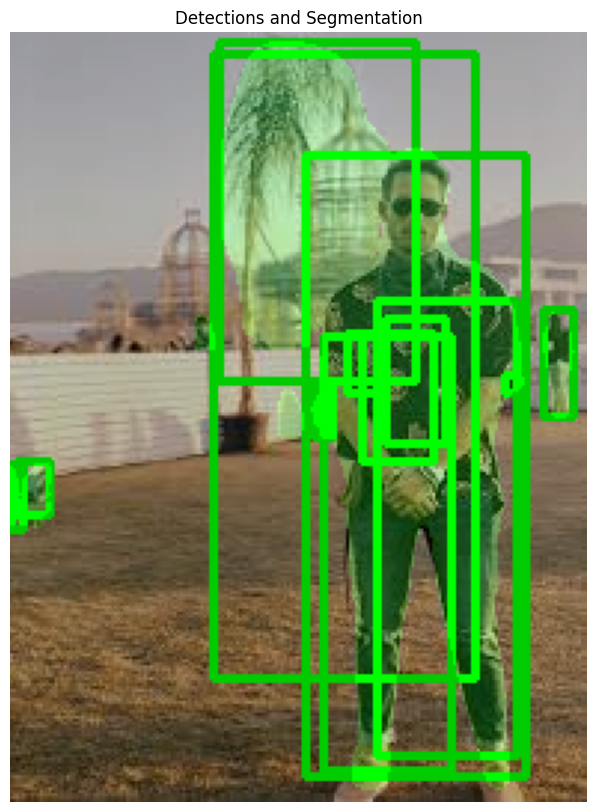

In [97]:
# sample_img = sample_img.unsqueeze(0) 
# # sample_img=r"C:\Users\raiha\Downloads\sample_img.jpg" # Add batch dimension

# # Detection
# with torch.no_grad():
#     detections = faster_rcnn(sample_img)
# print(detections)

# # Segmentation
# with torch.no_grad():
#     segmentations = mask_rcnn(sample_img)
# print(segmentations)

import torch
import cv2
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
import torchvision.transforms as T
import numpy as np

# ✅ Load pre-trained Faster R-CNN and Mask R-CNN models
faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()
mask_rcnn.eval()

# ✅ Load and preprocess sample image
image_path = r"C:\Users\raiha\Downloads\sample_img.jpg"
sample_img = cv2.imread(image_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
])
sample_img_tensor = transform(sample_img).unsqueeze(0)  # Add batch dimension

# ✅ Step 10: Test Model on Sample Data — Detection
with torch.no_grad():
    detections = faster_rcnn(sample_img_tensor)

# ✅ Extract detections (bounding boxes)
threshold = 0.5
boxes = [
    box.int().tolist()
    for box, score in zip(detections[0]["boxes"], detections[0]["scores"])
    if score > threshold
]

# ✅ Draw bounding boxes on the image
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(sample_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# ✅ Step 10: Test Model on Sample Data — Segmentation
with torch.no_grad():
    segmentations = mask_rcnn(sample_img_tensor)

# ✅ Extract segmentation masks
masks = (segmentations[0]["masks"] > 0.5).squeeze().cpu().numpy()
if masks.ndim == 3:
    masks = np.sum(masks, axis=0)

# ✅ Overlay segmentation mask
colored_mask = np.zeros_like(sample_img)
colored_mask[masks > 0] = (0, 255, 0)
blended_img = cv2.addWeighted(sample_img, 0.8, colored_mask, 0.2, 0)

# ✅ Display the final result
plt.figure(figsize=(10, 10))
plt.imshow(blended_img)
plt.axis("off")
plt.title("Detections and Segmentation")
plt.show()





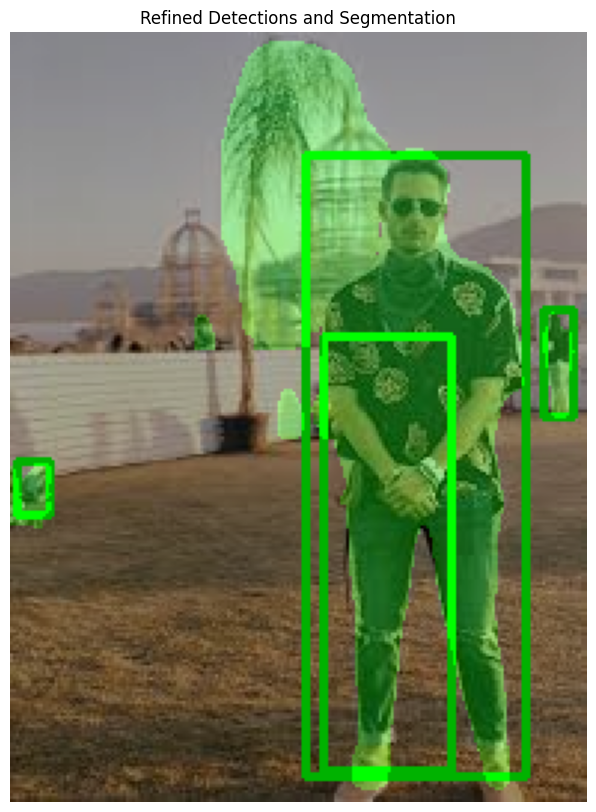

In [98]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn
import matplotlib.pyplot as plt

# ✅ Step 1: Load the image
image_path = r"C:\Users\raiha\Downloads\sample_img.jpg"
sample_img = cv2.imread(image_path)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

# ✅ Step 2: Define transformations
transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor()
])

# ✅ Step 3: Apply transformations & add batch dimension
sample_img_tensor = transform(sample_img).unsqueeze(0)

# ✅ Step 4: Load pre-trained models
faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True).eval()
mask_rcnn = maskrcnn_resnet50_fpn(pretrained=True).eval()

# ✅ Step 5: Perform object detection
with torch.no_grad():
    detections = faster_rcnn(sample_img_tensor)

# ✅ Step 6: Perform segmentation
with torch.no_grad():
    segmentations = mask_rcnn(sample_img_tensor)

# ✅ Step 7: Set confidence threshold
threshold = 0.8

# ✅ Step 8: Draw detection boxes
boxes = [
    box.int().tolist()
    for box, score in zip(detections[0]["boxes"], detections[0]["scores"])
    if score > threshold
]

# Draw blue bounding boxes
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(sample_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# ✅ Step 9: Process segmentation masks
masks = (segmentations[0]["masks"] > 0.5).squeeze().cpu().numpy()
if masks.ndim == 3:
    masks = np.sum(masks, axis=0)

# ✅ Step 10: Overlay segmentation mask with transparency
colored_mask = np.zeros_like(sample_img)
colored_mask[masks > 0] = (0, 255, 0)
blended_img = cv2.addWeighted(sample_img, 0.7, colored_mask, 0.3, 0)

# ✅ Step 11: Show the final visualization
plt.figure(figsize=(10, 10))
plt.imshow(blended_img)
plt.axis("off")
plt.title("Refined Detections and Segmentation")
plt.show()


#### ✅ Step 11: Save Preprocessed Data (Optional)


In [99]:
np.save("processed_images.npy", sample_img)
np.save("processed_masks.npy", sample_mask)


NameError: name 'sample_mask' is not defined